In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import hypergeom

from goatools.obo_parser import GODag
from goatools.associations import dnld_assc
from goatools.semantic import semantic_similarity
from goatools.semantic import TermCounts, get_info_content
from goatools.semantic import resnik_sim
from goatools.semantic import lin_sim
from goatools.associations import read_gaf
from goatools.semantic import deepest_common_ancestor

# personal modules
import databases as db
import kuzmin_data as data
import enrichment as enrich


In [4]:
np.sum(len(i) for i in db.gene_2_go.values())

<ipython-input-4-8c4fc777d0ce>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(len(i) for i in db.gene_2_go.values())


24087

In [5]:
obo_file = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/database/go_dot_org/go-basic.obo"
#gaf_file = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/database/go_dot_org/sgd.gaf"
gaf_file = "/Users/bjarnold/Downloads/tair.gaf"

godag = GODag(obo_file)
#fin_gaf = os.path.join(os.getcwd(), "tair.gaf")

go_id3 = 'GO:0006974'
go_id4 = 'GO:0006974'
print(godag[go_id3])
print(godag[go_id4])

/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/database/go_dot_org/go-basic.obo: fmt(1.2) rel(2022-07-01) 47,008 Terms
GO:0006974	level-04	depth-04	cellular response to DNA damage stimulus [biological_process]
GO:0006974	level-04	depth-04	cellular response to DNA damage stimulus [biological_process]


In [6]:
#associations = dnld_assc(gaf_file, godag)
associations = read_gaf(gaf_file)
termcounts = TermCounts(godag, associations)

HMS:0:00:05.059592 255,733 annotations READ: /Users/bjarnold/Downloads/tair.gaf 
28656 IDs in loaded association branch, BP


In [7]:
go_root = deepest_common_ancestor([go_id3, go_id4], godag)
print(go_root)

GO:0006974


In [8]:
go_id = "GO:0006974"
infocontent = get_info_content(go_id, termcounts)
print('Information content ({}) = {}'.format(go_id, infocontent))

Information content (GO:0006974) = 4.114649828382846


In [9]:
sim = semantic_similarity(go_id3, go_id4, godag)
print(sim)

1.0


In [10]:
sim_r = resnik_sim(go_id3, go_id4, godag, termcounts)
print('Resnik similarity score ({}, {}) = {}'.format(go_id3, go_id4, sim_r))
sim_l = lin_sim(go_id3, go_id4, godag, termcounts)
print('Lin similarity score ({}, {}) = {}'.format(go_id3, go_id4, sim_l))

Resnik similarity score (GO:0006974, GO:0006974) = 4.114649828382846
Lin similarity score (GO:0006974, GO:0006974) = 1.0


From the supplement of the Kuzmin et al 2020 paper: "The scoring of 537,911 double and 256,861 triple mutants identified 4,650 negative and 2,547 positive digenic interactions and 2,466 negative and 2,091 positive trigenic interactions."

In [11]:
kuzmin_2020_data_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2020"
kuzmin_2020_s1, kuzmin_2020_s1_digenic, kuzmin_2020_s1_trigenic = data.load_kuzmin_2020_s1(kuzmin_2020_data_dir)
kuzmin_2020_s3, kuzmin_2020_s3_digenic = data.load_kuzmin_2020_s3(kuzmin_2020_data_dir)
kuzmin_2020_s5, kuzmin_2020_s5_singMut, kuzmin_2020_s5_dblMut = data.load_kuzmin_2020_s5(kuzmin_2020_data_dir)
kuzmin_2020_s2 = data.load_kuzmin_2020_s2(kuzmin_2020_data_dir)


print(kuzmin_2020_s1.combined_mutant_type.value_counts())
print(kuzmin_2020_s2.combined_mutant_type.value_counts())


digenic     537911
trigenic    256861
Name: combined_mutant_type, dtype: int64
digenic     7197
trigenic    4557
Name: combined_mutant_type, dtype: int64


In [12]:
# create dictionaries of fitness/interaction values for quick lookup tables
# these will be used to recompute tau on cumulant and multiplicative scale

kuzmin_2020_s1_dblMutFit = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.double_triple_mutant_fitness))
kuzmin_2020_s1_epsilon = dict(zip(kuzmin_2020_s1_digenic.alleles, kuzmin_2020_s1_digenic.raw_interaction_score_epsilon))
kuzmin_2020_s1_singMutFit = dict(zip(kuzmin_2020_s1.array_allele_name, kuzmin_2020_s1.array_single_mutant_fitness))

kuzmin_2020_s3_singMutFit = dict(zip(kuzmin_2020_s3.array_allele_name, kuzmin_2020_s3.array_single_mutant_fitness))

kuzmin_2020_s5_dblMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Double mutant"]
kuzmin_2020_s5_singMut = kuzmin_2020_s5[kuzmin_2020_s5.mutant_type == "Single mutant"]

kuzmin_2020_s5_dblMutFit = dict(zip(kuzmin_2020_s5_dblMut.alleles, kuzmin_2020_s5_dblMut.fitness))
kuzmin_2020_s5_singMutFit = dict(zip(kuzmin_2020_s5_singMut.alleles, kuzmin_2020_s5_singMut.fitness))


**From the main text**:

Using colony size as a proxy for cell fitness, we measured the growth pheno- types of the set of 240 double-mutant query strains and the corresponding 480 single mu- tants (table S5) (42), which correlated well with previous large-scale measurements of single-mutant fitness (Pearson correlation co- efficient r =0.51, P =3×10−30)

**From the supplement**:

The mean single mutant fitness estimates of each array strain were obtained from a previous study (37).

**Conclusion**:

Double mutants:

- take ij mutants from Kuzmin 2020 S5

- take ik and jk mutants from Kuzmin 2020 S1

Single mutants:

- take i from Kuzmin 2020 S3?????

- take j from Kuzmin 2020 S5

- take k from Kuzmin 2020 S1


Consider three genes i, j, and k. Based on the experimental design of Kuzmin et al, they compute digenic interaction effects between genes i and k (e_ik) and between genes j and k (e_jk). Then, they cross the double mutant ij with single mutant k. This cross introduces 3 interaction effects: 2 digenic (e_ik and e_jk) and 1 trigenic (t_ijk). They compute the trigenic effect by subtracting out the two previously calculated digenic effects. Note that e_ij isn't calculated here but is accounted for in their eqn within f_ij.

For each triple mutant ijk, let's confirm that double mutants ik and jk exist:

In [13]:
f_i, f_j, f_k, f_ij, f_ik, f_jk, e_ik_kuz, e_jk_kuz = data.consolidate_fitnesses_across_tables(kuzmin_2020_s1_trigenic,
                                                                                            kuzmin_2020_s1_dblMutFit,
                                                                                            kuzmin_2020_s1_singMutFit,
                                                                                            kuzmin_2020_s1_epsilon,
                                                                                            kuzmin_2020_s3_singMutFit,
                                                                                            kuzmin_2020_s5_singMutFit,
                                                                                            kuzmin_2020_s5_dblMutFit)

# incorporate fitnesses into the data frame so that for each triplet of genes, we have all relevant fitness values in the same row to calculate interactions
# since we will be mostly using kuzmin_2020_s1_trigenic going forwards, lets rename it to df

df = kuzmin_2020_s1_trigenic

df['f_ij'] = df['alleles'].map(f_ij)
df['f_ik'] = df['alleles'].map(f_ik)
df['f_jk'] = df['alleles'].map(f_jk)

df['f_i'] = df['alleles'].map(f_i)
df['f_j'] = df['alleles'].map(f_j)
df['f_k'] = df['alleles'].map(f_k)

df['e_ik_kuz'] = df['alleles'].map(e_ik_kuz)
df['e_jk_kuz'] = df['alleles'].map(e_jk_kuz)



In [14]:

print(np.sum(~np.isnan(df.f_ij)))
print(np.sum(~np.isnan(df.f_ik)))
print(np.sum(~np.isnan(df.f_jk)))
print(np.sum(~np.isnan(df.f_i)))
print(np.sum(~np.isnan(df.f_j)))
print(np.sum(~np.isnan(df.f_k)))
print()
print(np.sum(~np.isnan(df.e_ik_kuz)))
print(np.sum(~np.isnan(df.e_jk_kuz)))

#print(len(df.f_ik))
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])))
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk'])))
print(len(df))
print("fraction of gene triplets for which we were able to find all relevant fitness values")
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk']))/len(df))
print("number of gene triplets for which we were able to find all relevant fitness values")
print(len(df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk'])))


215617
256850
256773
226427
254763
256861

256850
256773
189340
189340
256861
fraction of gene triplets for which we were able to find all relevant fitness values
0.7371301988234882
number of gene triplets for which we were able to find all relevant fitness values
189340


fraction of tau values that remain after filtering out deviants


<ipython-input-15-7c436393ed1b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tau_kuzmin_orig'] = df.double_triple_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i


0.9891940424632936


,tau_kuzmin_orig,adjusted_interaction_score_epsilon_or_tau
tau_kuzmin_orig,1.000000,0.997447
adjusted_interaction_score_epsilon_or_tau,0.997447,1.000000


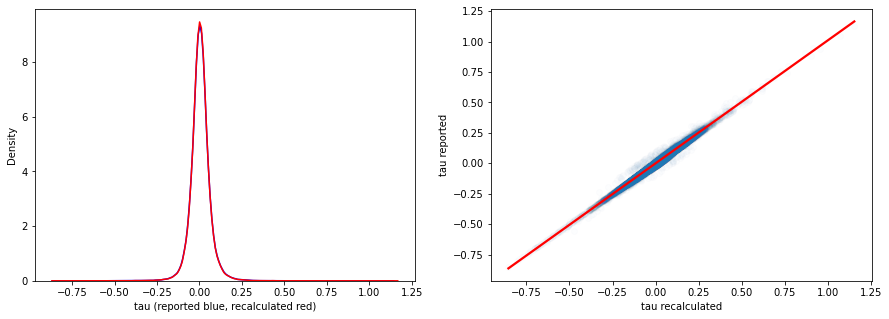

In [15]:
# To ensure we appropriately understand the data, we recalculate tau (trigenic interaction) using the formula in the supplement of Kuzmin 2018.
# These values *should* correspond to those reported in the 'adjusted_interaction_score_epsilon_or_tau' column. Around ~1% of recalculated tau values
# strongly deviate from those reported, and we filter these out.

df = df.dropna(subset=['f_i', 'f_j', 'f_k', 'f_ij', 'f_ik', 'f_jk', 'e_ik_kuz', 'e_jk_kuz'])
threshold = 0.1

df['tau_kuzmin_orig'] = df.double_triple_mutant_fitness - df.f_ij*df.f_k - df.e_ik_kuz*df.f_j - df.e_jk_kuz*df.f_i

# filter out results that aren't reproducible according to the original equation
print("fraction of tau values that remain after filtering out deviants")
print(len(df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold])/len(df))

df = df[abs(df.tau_kuzmin_orig - df.adjusted_interaction_score_epsilon_or_tau) <= threshold]

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df['tau_kuzmin_orig'], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, recalculated red)')

p = sns.regplot(x=df['tau_kuzmin_orig'],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau recalculated', ylabel='tau reported')

df[['tau_kuzmin_orig', 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")


In [16]:
# recalculate tau using isserlis formula (rearrangement of formula in Kuzmin et al 2018) and multiplicative formula

df.loc[:, 'tau_isserlis'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk - df.f_j*df.f_ik - df.f_k*df.f_ij

df.loc[:,'e_ik_mult'] = df.f_ik/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult'] = df.f_jk/(df.f_j*df.f_k)
#df.loc[:,'tau_multiplicative'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult*df.e_jk_mult) 
df.loc[:,'tau_multiplicative'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik*df.f_jk) 




In [17]:
# tau_isserlis (forumula from cumulant formula) calculated above should be equivalent to tau_kuzmin_orig (formula from Kuzmin et al 2018).
# One can substitute (f_jk - f_j*f_k) for e_jk and (f_ik - f_i*f_k) for e_ik into the Kuzmin et al 2018 formula to get the cumulant formula
# However, the results using these two equivalent formula aren't the same because  f_jk != (f_j*f_k + e_jk) and  f_ik != (f_i*f_k + e_ik)

# subsituting in (f_j*f_k + e_jk) for f_jk and (f_i*f_k + e_ik) for f_ik
# This gives trigenic interaction scores that are similar to reported values, see sanityChecks notebook
# newly recalculated double mutant fitnesses, and corresponding interactions, are suffixed with 2

df.loc[:, 'f_ik_2'] = df.f_i*df.f_k + df.e_ik_kuz
df.loc[:, 'f_jk_2'] = df.f_j*df.f_k + df.e_jk_kuz

df.loc[df['f_ik_2'] < 0, ['f_ik_2']] = np.nan
df.loc[df['f_jk_2'] < 0, ['f_jk_2']] = np.nan

df.loc[:,'e_ik_mult2'] = df.f_ik_2/(df.f_i*df.f_k)
df.loc[:,'e_jk_mult2'] = df.f_jk_2/(df.f_j*df.f_k)

df.loc[:, 'tau_isserlis2'] = df.double_triple_mutant_fitness + 2*df.f_i*df.f_j*df.f_k - df.f_i*df.f_jk_2 - df.f_j*df.f_ik_2 - df.f_k*df.f_ij

# calculate multiplicative results using the custom dbl mutant fitnesses that gave results consistent with those reported (above)
# compare these with tau_isserlis2
#df.loc[:,'tau_multiplicative2'] = df.double_triple_mutant_fitness/(df.f_ij*df.f_k*df.e_ik_mult2*df.e_jk_mult2) 
df.loc[:,'tau_multiplicative2'] = (df.double_triple_mutant_fitness*df.f_i*df.f_j*df.f_k)/(df.f_ij*df.f_ik_2*df.f_jk_2) 


,tau_isserlis2,adjusted_interaction_score_epsilon_or_tau
tau_isserlis2,1.000000,0.997449
adjusted_interaction_score_epsilon_or_tau,0.997449,1.000000


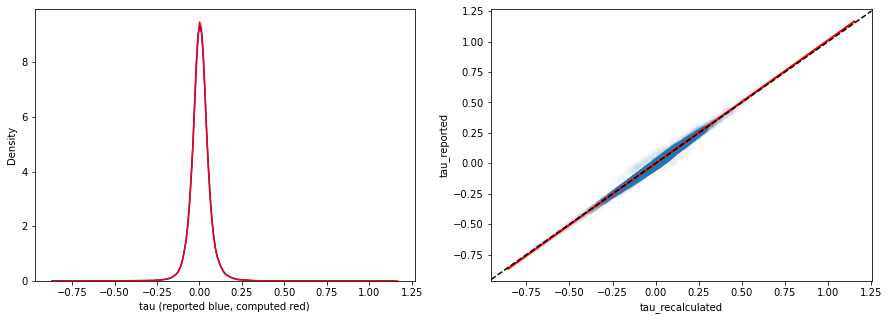

In [18]:
tau = "tau_isserlis2"

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

p = sns.kdeplot(df['adjusted_interaction_score_epsilon_or_tau'], ax=axs[0], color="blue")
p = sns.kdeplot(df[tau], ax=axs[0], color="red")
p.set(xlabel='tau (reported blue, computed red)')

p = sns.regplot(x=df[tau],
            y=df['adjusted_interaction_score_epsilon_or_tau'],
            scatter_kws={'alpha':0.01},
            line_kws={'color': 'red'},
            ax=axs[1])
p.set(xlabel='tau_recalculated', ylabel='tau_reported')
axs[1].axline([-0.75, -0.75], [1, 1], linestyle="--", color="black")

df[[tau, 'adjusted_interaction_score_epsilon_or_tau']].corr(method="pearson")

In [19]:
# This logical switch is used to change all downstream analyses

use_reported_double_mutant_fitnesses = False
compare_to_reported_values = True # if False, compare instead to values recalculated with isserlis formula

if use_reported_double_mutant_fitnesses:
    multiplicative = "tau_multiplicative"
    isserlis = "tau_isserlis"
else:
    multiplicative = "tau_multiplicative2"
    isserlis = "tau_isserlis2"

if compare_to_reported_values:
    compare = "adjusted_interaction_score_epsilon_or_tau"
else:
    compare = isserlis

In [20]:
# To see how outliers vary across scales, we can calculate a significance threshold for the multiplicative scale by 
# finding the quantile that corresponds +/- 0.08, the trigenic score Kuzmin et al use to find positive/negative outliers.

tau_reported_sig_quant, tau_mult_sig_val, tau_iss_sig_val = {},{},{}

# get quantiles
tau_reported_sig_quant['neg'] = np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) < -0.08)
tau_reported_sig_quant['pos'] = 1 - np.mean( np.array(df.adjusted_interaction_score_epsilon_or_tau) > 0.08)

# calculate significance thresholds on new scales using quantile
tau_mult_sig_val['neg'] = np.nanquantile(df[multiplicative], tau_reported_sig_quant['neg'])
tau_mult_sig_val['pos'] = np.nanquantile(df[multiplicative], tau_reported_sig_quant['pos'])

tau_iss_sig_val['neg'] = np.nanquantile(df[isserlis], tau_reported_sig_quant['neg'])
tau_iss_sig_val['pos'] = np.nanquantile(df[isserlis], tau_reported_sig_quant['pos'])

print("quantiles of the significant values they used",  tau_reported_sig_quant['neg'], tau_reported_sig_quant['pos'] )
print("confirming (should be -0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_sig_quant['neg']))
print("confirming (should be 0.08):", np.quantile(df.adjusted_interaction_score_epsilon_or_tau, tau_reported_sig_quant['pos']))
print()
print( "corresponding cutoffs for multiplicative model: ", tau_mult_sig_val['neg'], tau_mult_sig_val['pos'])
print( "corresponding cutoffs for isserlis model: ", tau_iss_sig_val['neg'], tau_iss_sig_val['pos'])



quantiles of the significant values they used 0.0505675568891689 0.9305530342669813
confirming (should be -0.08): -0.07998675851335334
confirming (should be 0.08): 0.07998704170448599

corresponding cutoffs for multiplicative model:  0.9051323011432824 1.1071547776828774
corresponding cutoffs for isserlis model:  -0.07906997897906282 0.07887639643511797


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


                                           tau_multiplicative2  \
tau_multiplicative2                                   1.000000   
adjusted_interaction_score_epsilon_or_tau             0.983062   

                                           adjusted_interaction_score_epsilon_or_tau  
tau_multiplicative2                                                         0.983062  
adjusted_interaction_score_epsilon_or_tau                                   1.000000  
                                           tau_multiplicative2  \
tau_multiplicative2                                   1.000000   
adjusted_interaction_score_epsilon_or_tau             0.915095   

                                           adjusted_interaction_score_epsilon_or_tau  
tau_multiplicative2                                                         0.915095  
adjusted_interaction_score_epsilon_or_tau                                   1.000000  
                                           tau_multiplicative2  \
tau_multiplica

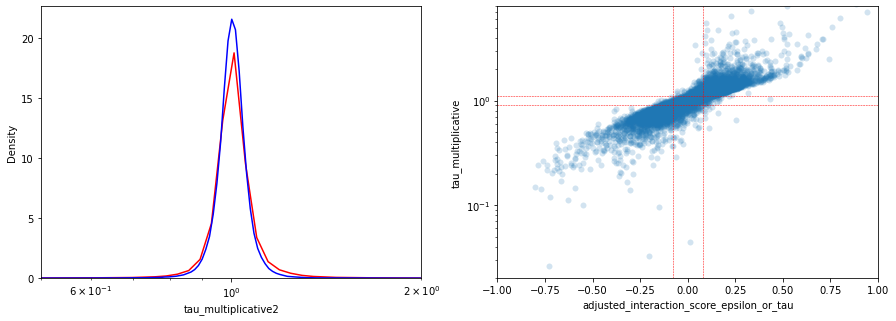

In [21]:
# How do multiplicative values compare to 

fig, axs = plt.subplots(ncols=2, figsize=(15,5))

bw_param =10
p = sns.kdeplot(df[multiplicative], ax = axs[0], color="red", log_scale=True)
# add one so distributions are more comparable
p = sns.kdeplot(df[compare]+1, ax = axs[0], color="blue")
axs[0].set_xlim(0.5,2)

p = sns.scatterplot(x=df[compare],
            y=df[multiplicative],
            alpha=0.2,
            linewidth=0,
            ax=axs[1])
p.set(xlabel=compare, ylabel='tau_multiplicative')
axs[1].set_xlim(-1,1)
axs[1].set_yscale('log')
axs[1].set_ylim(0.02,8)
axs[1].axhline(tau_mult_sig_val['neg'], color="red", linestyle="--", linewidth=0.5)
axs[1].axhline(tau_mult_sig_val['pos'], color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(-0.08, color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(0.08, color="red", linestyle="--", linewidth=0.5)

print(df[[multiplicative, compare]].corr(method="spearman"))
print(df[[multiplicative, compare]].corr(method="kendall"))
print(df[[multiplicative, compare]].corr(method="pearson"))


In [22]:
def count_frac(df):
    return len(df)
    
results = defaultdict(list)
p = 0.05

overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment( df[df.pval < p], "negative", count_frac, multiplicative, tau_mult_sig_val)
denom = overlap + only_reported + only_mult

results['type'].extend(['overlap_negative', 'only reported negative', 'only mult negative'])
results['number'].extend([overlap, only_reported, only_mult])
results['frac'].extend([overlap/denom, only_reported/denom, only_mult/denom])

overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment( df[df.pval < p], "positive", count_frac, multiplicative, tau_mult_sig_val)
denom = overlap + only_reported + only_mult

results['type'].extend(['overlap_positive', 'only reported positive', 'only mult positive'])
results['number'].extend([overlap, only_reported, only_mult])
results['frac'].extend([overlap/denom, only_reported/denom, only_mult/denom])

pd.DataFrame.from_dict(results)


,type,number,frac
0,overlap_negative,1527,0.729226
1,only reported negative,91,0.043457
2,only mult negative,476,0.227316
3,overlap_positive,1197,0.756637
4,only reported positive,126,0.079646
5,only mult positive,259,0.163717


In [49]:
# See if outliers are enriched for other biological signals. Here we load in pairwise physical interactions from one of two databases.
# 'physical_pairwise_interactions_set' contains a set of sorted 2-tuples of genes particupating in pairwise protein interactions

#physical_pairwise_interactions_set = db.get_physical_interactions_yeastGenomeDotOrg()

# BIOGRID contains physical interactions measured from a variety of assays including co-localization
# see here for explanation of experimental evidence codes: https://wiki.thebiogrid.org/doku.php/experimental_systems
db_interactions = db.get_physical_interactions_BIOGRID()
experimental_systems = ['Affinity Capture-MS', 'Affinity Capture-Western', 'Two-hybrid', 'Reconstituted Complex', 'PCA', 'Co-purification', 'Co-crystal Structure']
#experimental_systems = ['Affinity Capture-RNA']
#experimental_systems = ['Biochemical Activity']
#experimental_systems = ['Co-localization']
#print(db_interactions.experimental_system.value_counts())

db_interactions = db_interactions[db_interactions.experimental_system.isin(experimental_systems)]
#db_interactions = db_interactions[db_interactions.experimental_system_type == "physical"]
#db_interactions

In [50]:

physical_pairwise_interactions_set = db.find_unique_interactions(db_interactions, 'official_symbol_interactor_a', 'official_symbol_interactor_b')
num_physical_interactions, twoplus_physical_interactions, three_physical_interactions = db.count_interactions_in_set(df, physical_pairwise_interactions_set)
#df['num_physical_interactions'] = df['alleles'].map(num_physical_interactions)
#df['twoplus_physical_interactions'] = df['alleles'].map(twoplus_physical_interactions)
df['three_physical_interactions'] = df['alleles'].map(three_physical_interactions)

#print()
#print(df['num_physical_interactions'].value_counts())

physical_pairwise_interactions_dict = db.collect_interactions_in_dict(db_interactions, 'official_symbol_interactor_a', 'official_symbol_interactor_b')
three_shared_physical_interactions = db.count_shared_interactions_in_dict(df, physical_pairwise_interactions_dict, 1)
df['three_shared_physical_interactions'] = df['alleles'].map(three_shared_physical_interactions)




In [52]:
print(len(physical_pairwise_interactions_dict.keys()))
print(np.sum([len(i) for i in physical_pairwise_interactions_dict.values()]))

print(len(three_shared_physical_interactions.keys()))
print(np.sum([i for i in three_shared_physical_interactions.values()]))

print(np.sum(df['three_shared_physical_interactions']))
#physical_pairwise_interactions_dict
#three_shared_physical_interactions

6432
206363
187294
22736
22736


In [26]:
def mk_barplot_single(genome_wide, overlap, only_reported, only_mult, all_reported, all_mult):
    bars = ('overlap', 'only_reported', 'only_mult', 'all_reported', 'all_mult')
    x_pos = np.arange(len(bars))
    height = [overlap/genome_wide, only_reported/genome_wide, only_mult/genome_wide, all_reported/genome_wide, all_mult/genome_wide]
    plt.bar(x_pos, height)
    bars = ('overlap', 'only reported', 'only mult', 'all reported', 'all mult')
    x_pos = np.arange(len(bars))
    plt.xticks(x_pos, bars)
    plt.ylabel("fold enrichment")
    plt.xlabel("category")

def mk_barplot(genome_wide, overlap, only_reported, only_mult, all_reported, all_mult, i):
    bars = ('overlap', 'only_reported', 'only_mult', 'all_reported', 'all_mult')
    x_pos = np.arange(len(bars))
    height = [overlap/genome_wide, only_reported/genome_wide, only_mult/genome_wide, all_reported/genome_wide, all_mult/genome_wide]
    axs[i].bar(x_pos, height)
    axs[i].xaxis.set_ticks([])

def mk_barplot_both_tails(genome_wide, all_reported, all_mult):
    bars = ('genome_wide', 'all_reported', 'all_mult')
    x_pos = np.arange(len(bars))
    height = [genome_wide, all_reported, all_mult]
    plt.bar(x_pos, height)
    #plt.xaxis.set_ticks([])
   



([<matplotlib.axis.XTick at 0x7fae9fe6a8b0>,
 [Text(0, 0, 'overlap'),
  Text(1, 0, 'only reported'),
  Text(2, 0, 'only mult'),
  Text(3, 0, 'all reported'),
  Text(4, 0, 'all mult')])

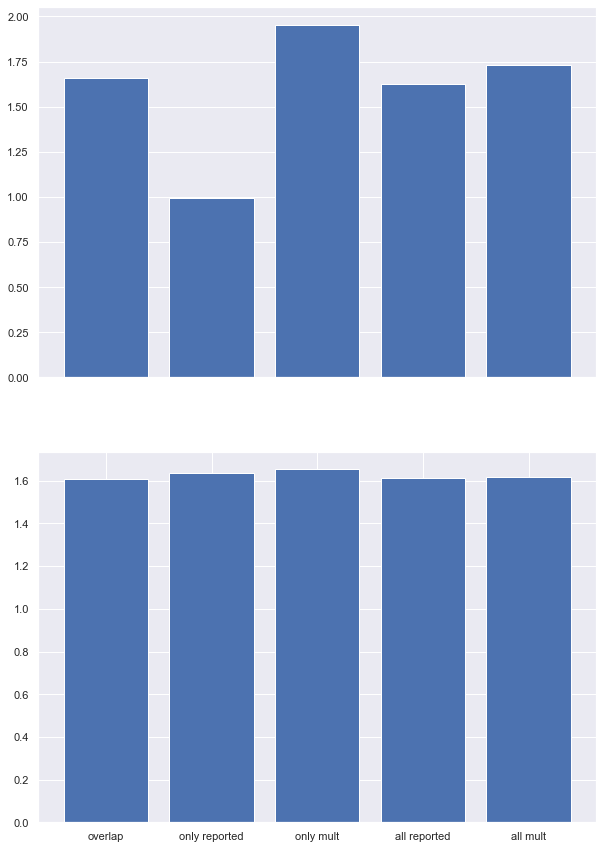

In [51]:
# functions to use to explore pbhysical interactions: fraction_physical_twoplus, fraction_physical_three
fig, axs = plt.subplots(nrows=2, figsize=(10,15))
sns.set(font_scale = 1)

#func = enrich.fraction_physical_three
func = enrich.fraction_three_shared
p = 0.05

genome_wide = func(df)

overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", func, multiplicative, tau_mult_sig_val)
mk_barplot(genome_wide['frac'], overlap['frac'], only_reported['frac'], only_mult['frac'], all_reported['frac'], all_mult['frac'], 0)

overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "positive", func, multiplicative, tau_mult_sig_val)
mk_barplot(genome_wide['frac'], overlap['frac'], only_reported['frac'], only_mult['frac'], all_reported['frac'], all_mult['frac'], 1)

bars = ('overlap', 'only reported', 'only mult', 'all reported', 'all mult')
x_pos = np.arange(len(bars))
plt.xticks(x_pos, bars)


In [28]:
print(enrich.perform_hypergeom_test(df, "negative", enrich.fraction_three_shared, multiplicative, tau_mult_sig_val))

            type          pval
0        overlap  0.000000e+00
1  only_reported  4.265093e-01
2      only_mult  0.000000e+00
3   all_reported  1.983642e-10
4       all_mult  0.000000e+00


In [29]:
print(enrich.perform_hypergeom_test(df, "negative", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val))

            type          pval
0        overlap  0.000000e+00
1  only_reported  1.807779e-01
2      only_mult  6.542915e-09
3   all_reported  2.095401e-10
4       all_mult  0.000000e+00


In [30]:
print(enrich.perform_hypergeom_test(df, "positive", enrich.alleles_2_go_enrichment, multiplicative, tau_mult_sig_val))

            type      pval
0        overlap  0.000535
1  only_reported  0.084524
2      only_mult  0.000074
3   all_reported  0.000295
4       all_mult  0.000003


In [31]:
# arg that goes into get_coexpression_gene_pairs is the z-score associated with how significant the correlation b/t expression is
coexpression_gene_pairs_set = db.get_coexpression_gene_pairs(4)

num_coex_interactions, twoplus_coex_interactions, three_coex_interactions = db.count_interactions_in_set(df, coexpression_gene_pairs_set)

df['num_coex_interactions'] = df['alleles'].map(num_coex_interactions)
df['twoplus_coex_interactions'] = df['alleles'].map(twoplus_coex_interactions)
df['three_coex_interactions'] = df['alleles'].map(three_coex_interactions)

print(df['num_coex_interactions'].value_counts())



0    154370
1     32642
2       179
3       103
Name: num_coex_interactions, dtype: int64


([<matplotlib.axis.XTick at 0x7fae9c8b1bb0>,
 [Text(0, 0, 'genome_wide'),
  Text(1, 0, 'overlap'),
  Text(2, 0, 'only_reported'),
  Text(3, 0, 'only_mult'),
  Text(4, 0, 'all_reported'),
  Text(5, 0, 'all_mult')])

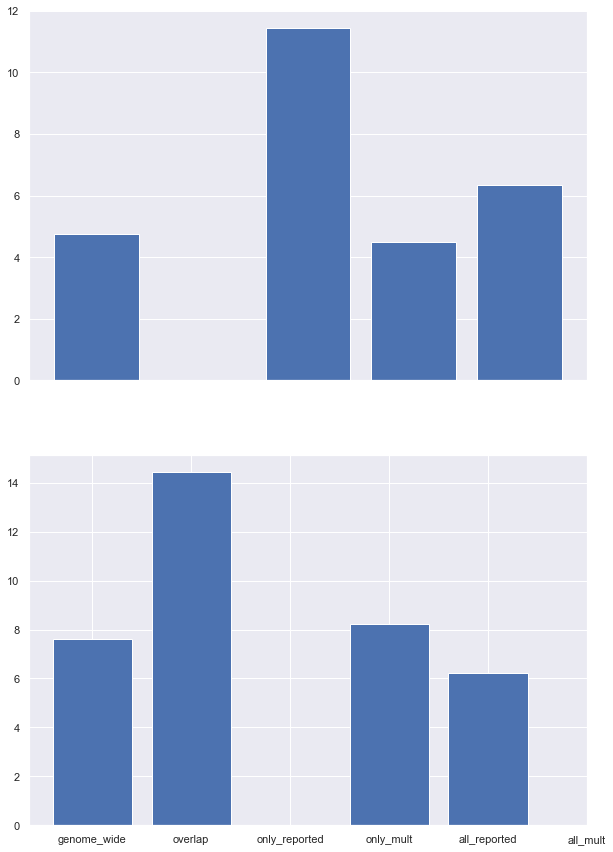

In [32]:
# functions to use to explore pbhysical interactions: fraction_physical_twoplus, fraction_physical_three
fig, axs = plt.subplots(nrows=2, figsize=(10,15))

func = enrich.fraction_coex_three
p = 0.05

genome_wide = func(df)

overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", func, multiplicative, tau_mult_sig_val)
mk_barplot(genome_wide['frac'], overlap['frac'], only_reported['frac'], only_mult['frac'], all_reported['frac'], all_mult['frac'], 0)

overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "positive", func, multiplicative, tau_mult_sig_val)
mk_barplot(genome_wide['frac'], overlap['frac'], only_reported['frac'], only_mult['frac'], all_reported['frac'], all_mult['frac'], 1)

bars = ('genome_wide', 'overlap', 'only_reported', 'only_mult', 'all_reported', 'all_mult')
x_pos = np.arange(len(bars))
plt.xticks(x_pos, bars)


In [33]:
p = 0.05
data = []
for func in [enrich.fraction_coex_three, enrich.fraction_three_shared, enrich.alleles_2_go_enrichment]:
    genome_wide = func(df)
    overlap, only_reported, only_mult, all_reported, all_mult = enrich.outlier_enrichment(df[df.pval < p], "negative", func, multiplicative, tau_mult_sig_val)

    d = [overlap['frac']/genome_wide['frac'], only_reported['frac']/genome_wide['frac'], only_mult['frac']/genome_wide['frac'], all_reported['frac']/genome_wide['frac'], all_mult['frac']/genome_wide['frac']]
    data.append( d )


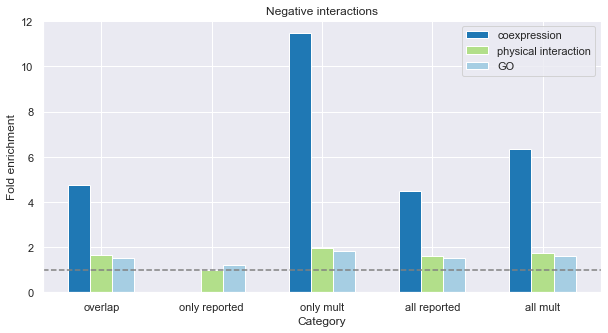

In [34]:
fig, axs = plt.subplots(figsize=(10,5))

x = np.arange(len(data[0]))
width = 0.2

plt.bar(x-width, data[0], width, color='#1f78b4')
plt.bar(x, data[1], width, color='#b2df8a')
plt.bar(x+width, data[2], width, color='#a6cee3')
plt.xticks(x, ['overlap', 'only reported', 'only mult', 'all reported', 'all mult'])
plt.xlabel("Category")
plt.ylabel("Fold enrichment")
plt.legend(["coexpression", "physical interaction", "GO"])
plt.title("Negative interactions")
plt.axhline(1, linestyle="--", color="gray")
plt.show()

In [35]:
# look at gene triplets for different multiplicative outliers not reported as significant; inspect as jupyter variables in VS code
x1 = sorted(df[df.pval < 0.05].alleles[(df[df.pval < 0.05].adjusted_interaction_score_epsilon_or_tau < 0.08) & (df[df.pval < 0.05][multiplicative] > tau_mult_pos_sig_val)])
x2 = sorted(df[df.pval < 0.05].alleles[(df[df.pval < 0.05].adjusted_interaction_score_epsilon_or_tau > -0.08) & (df[df.pval < 0.05][multiplicative] < tau_mult_neg_sig_val)])
x3 = sorted(df[df.pval < 0.05].alleles[(df[df.pval < 0.05].adjusted_interaction_score_epsilon_or_tau < -0.08) & (df[df.pval < 0.05][multiplicative] > tau_mult_neg_sig_val)])

NameError: name 'tau_mult_pos_sig_val' is not defined

In [ ]:
test = pd.read_csv("/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/KuzminEtAl2020/aaz5667-Table-S8.txt", sep="\t", encoding = "ISO-8859-1")
test

,DM strainID,SM1 strainID,SM2 strainID,ORF1,ORF2,Gene1,Gene2,Ohnolog (A-A) or Homeolog (A-AB)
0,tm143,tm405,tm2305,YBR014C,YDL010W,GRX7,GRX6,A - AB
1,tm164,tm550,tm2249,YLL012W,YLR020C,YEH1,YEH2,A - AB
2,tm1509,tm651,tm362,YHR001W,YKR003W,OSH7,OSH6,A - AB
3,tm3397,tm697,tm2295,YGR243W,YHR162W,MPC3,MPC2,A - AB
4,tm170,tm468,tm1283,YJR091C,YPR042C,JSN1,PUF2,A - AB
...,...,...,...,...,...,...,...,...
235,tm108,tm596,tm1150,YMR222C,YOR280C,FSH2,FSH3,NaN
236,tm1554,tm1861,tm1805,YAL051W,YOR363C,OAF1,PIP2,NaN
237,tm1616,tm576,tm1207,YGL082W,YPL191C,YGL082W,YPL191C,NaN
238,tm95,tm448,tm1137,YMR175W,YPL223C,SIP18,GRE1,NaN


NameError: name 'tmp_pos' is not defined

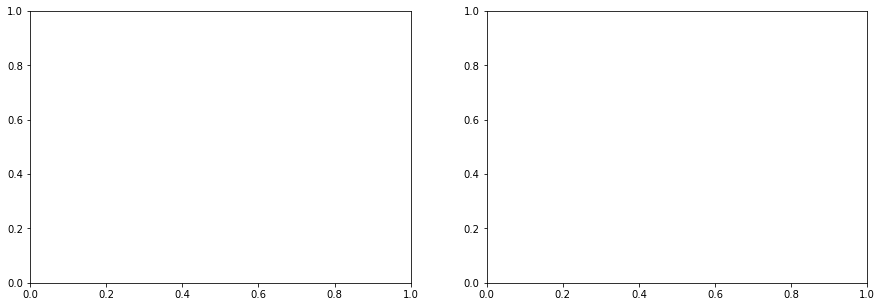

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(15,5))

pos_multiplicative_alleles = tmp_pos.alleles[(tmp_pos.array_allele_name_x.isna()) & (tmp_pos.array_allele_name_y.notna())]
tmp = df.loc[df['alleles'].isin(pos_multiplicative_alleles)]

p = sns.scatterplot(x=tmp[isserlis],
            y=tmp[multiplicative],
            alpha=0.3,
            linewidth=0,
            ax=axs[0])
axs[0].set(xlabel='tau_cumulant', ylabel='tau_multiplicative')
#p.set_xlim(-1,1)
axs[0].set_yscale('log')
#p.set_ylim(0.02,8)
axs[0].axhline(tau_mult_neg_sig_val, color="red", linestyle="--", linewidth=0.5)
axs[0].axhline(tau_mult_pos_sig_val, color="red", linestyle="--", linewidth=0.5)
axs[0].axvline(-0.08, color="red", linestyle="--", linewidth=0.5)
axs[0].axvline(0.08, color="red", linestyle="--", linewidth=0.5)
axs[0].axvline(0.0, color="black", linestyle="--", linewidth=0.5)

neg_multiplicative_alleles = tmp_neg.alleles[(tmp_neg.array_allele_name_x.isna()) & (tmp_neg.array_allele_name_y.notna())]
tmp = df.loc[df['alleles'].isin(neg_multiplicative_alleles)]

p = sns.scatterplot(x=tmp[isserlis],
            y=tmp[multiplicative],
            alpha=0.3,
            linewidth=0,
            ax=axs[1])
axs[1].set(xlabel='tau_cumulant', ylabel='tau_multiplicative')
#p.set_xlim(-1,1)
axs[1].set_yscale('log')
#p.set_ylim(0.02,8)
axs[1].axhline(tau_mult_neg_sig_val, color="red", linestyle="--", linewidth=0.5)
axs[1].axhline(tau_mult_pos_sig_val, color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(-0.08, color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(0.08, color="red", linestyle="--", linewidth=0.5)
axs[1].axvline(0.0, color="black", linestyle="--", linewidth=0.5)


<AxesSubplot:xlabel='adjusted_interaction_score_epsilon_or_tau', ylabel='Density'>

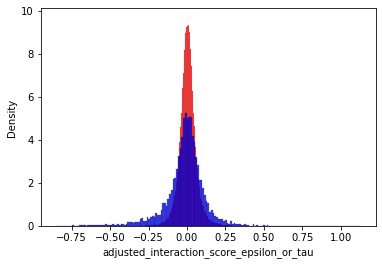

In [ ]:
sns.histplot(df.adjusted_interaction_score_epsilon_or_tau, color="red", stat="density")
sns.histplot(df_sig.adjusted_interaction_score_epsilon_or_tau, color="blue", stat="density")

1.0657718662406535
0.9626505926200865
2.475594397354814


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


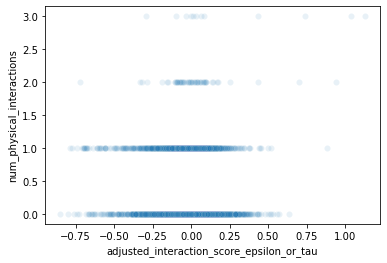

In [ ]:

p = sns.scatterplot(df_sig.adjusted_interaction_score_epsilon_or_tau,df_sig.num_physical_interactions, alpha=0.1)


#tmp = "adjusted_interaction_score_epsilon_or_tau"
tmp = multiplicative

#print(np.nanmean( df_sig[tmp][(df_sig[tmp] > 0) & (df_sig.oneplus_physical_interactions == 0)] ))
#print(np.nanmean( df_sig[tmp][(df_sig[tmp] > 0) & (df_sig.oneplus_physical_interactions == 1)] ))

print(np.nanmean( df_sig[tmp][ df_sig.num_physical_interactions == 0] ))
print(np.nanmean( df_sig[tmp][ df_sig.num_physical_interactions == 1] ))
print(np.nanmean( df_sig[tmp][ df_sig.num_physical_interactions >= 2] ))

#print(np.nanmedian(df_sig.adjusted_interaction_score_epsilon_or_tau[df_sig.oneplus_physical_interactions == 0]))
#print(np.nanmedian(df_sig.adjusted_interaction_score_epsilon_or_tau[df_sig.oneplus_physical_interactions == 1]))

#print(np.nanmedian(df_sig[multiplicative][df_sig.oneplus_physical_interactions == 0]))
#print(np.nanmedian(df_sig[multiplicative][df_sig.oneplus_physical_interactions == 1]))

In [ ]:
#tmp = "adjusted_interaction_score_epsilon_or_tau"
tmp = multiplicative

subset = df_sig[tmp].notna()

X = np.array(df_sig[tmp][subset]).reshape(-1,1)
Y = df_sig.twoplus_physical_interactions[subset]
print(len(X))

res = LogisticRegression(random_state=0).fit(np.log(X), Y)
print(res.coef_)
print(res.intercept_)

7957


<ipython-input-56-e55ec59d5644>:10: RuntimeWarning: invalid value encountered in log
  res = LogisticRegression(random_state=0).fit(np.log(X), Y)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
np.log(X)

<ipython-input-55-1ce7a68dd2e6>:1: RuntimeWarning: invalid value encountered in log
  np.log(X)


array([[-0.02488511],
       [-0.05874193],
       [ 0.15539719],
       ...,
       [ 0.15232418],
       [-0.01888488],
       [-0.43202115]])

In [ ]:
neg_multiplicative_alleles = tmp_neg.alleles[(tmp_neg.array_allele_name_x.isna()) & (tmp_neg.array_allele_name_y.notna())]
tmp = df.loc[df['alleles'].isin(neg_multiplicative_alleles)]

x = tmp[(tmp.adjusted_interaction_score_epsilon_or_tau>0.00)][["alleles", "adjusted_interaction_score_epsilon_or_tau", isserlis, multiplicative]].sort_values(by="alleles")
x.tail(30)


,alleles,adjusted_interaction_score_epsilon_or_tau,tau_isserlis2,tau_multiplicative2
5529,"gpb2,gpb1,sse1",0.028460,0.021538,0.665096
4919,"gpb2,gpb1,yor1",0.005877,-0.028110,0.836707
40512,"kcc4,gin4,nbp2",0.089002,0.082251,0.904207
244756,"kin4,frk1,sac1",0.000649,-0.009849,0.787189
202370,"mlp1,mlp2,swr1",0.007475,0.011040,0.899984
232423,"msg5,sdp1,pmr1",0.010977,0.008417,0.899355
48504,"npp1,npp2,clg1",0.097607,0.073630,0.866068
48580,"npp1,npp2,rpn1-821",0.009683,-0.001547,0.806872
223090,"nup53,asm4,BET3-ph",0.000562,0.004658,0.726107
222628,"nup53,asm4,TRS23-PH",0.059092,0.065270,0.563035


In [ ]:
pos_multiplicative_alleles = tmp_pos.alleles[(tmp_pos.array_allele_name_x.isna()) & (tmp_pos.array_allele_name_y.notna())]
tmp = df.loc[df['alleles'].isin(pos_multiplicative_alleles)]

tmp[(tmp.adjusted_interaction_score_epsilon_or_tau<0.00)][["alleles", "adjusted_interaction_score_epsilon_or_tau", isserlis, multiplicative]].sort_values(by="alleles")


,alleles,adjusted_interaction_score_epsilon_or_tau,tau_isserlis2,tau_multiplicative2
49814,"are1,are2,bck1",-0.014766,-0.013266,1.110828
50274,"are1,are2,chl1",-0.017532,-0.015424,1.206408
50260,"are1,are2,myo2-14",-0.021713,-0.020670,1.133033
49818,"are1,are2,pam16-3",-0.002152,-0.001603,1.114013
49968,"are1,are2,sed5-1",-0.049710,-0.050641,1.130057
227988,"cik1,vik1,sup35-td",-0.025101,0.020738,75.337056
91961,"heh2,src1,pom34",-0.015177,-0.019067,1.108816
91486,"heh2,src1,sac3",-0.021025,-0.019787,1.246198
91355,"heh2,src1,sec66",-0.028749,-0.031521,1.255338
130541,"lsb1,pin3,cog3-1",-0.056894,-0.023561,1.173636


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


                       tau_isserlis2_x  tau_multiplicative2_y
tau_isserlis2_x               1.000000               0.702297
tau_multiplicative2_y         0.702297               1.000000
                       tau_isserlis2_x  tau_multiplicative2_y
tau_isserlis2_x               1.000000               0.156976
tau_multiplicative2_y         0.156976               1.000000


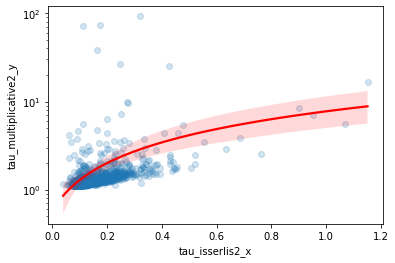

In [ ]:
tmp = tmp_pos[(tmp_pos.array_allele_name_x.notna()) & (tmp_pos.array_allele_name_y.notna())] 
p = sns.regplot(tmp[f'{isserlis}_x'],
            tmp[f'{multiplicative}_y'],
            scatter_kws={'alpha':0.2},
            line_kws={'color': 'red'})
p.set(yscale="log")
print(tmp[[f'{isserlis}_x', f'{multiplicative}_y']].corr(method="spearman"))
print(tmp[[f'{isserlis}_x', f'{multiplicative}_y']].corr(method="pearson"))


/Users/bjarnold/miniconda/envs/datascience/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


                       tau_isserlis2_x  tau_multiplicative2_y
tau_isserlis2_x               1.000000               0.805207
tau_multiplicative2_y         0.805207               1.000000
                       tau_isserlis2_x  tau_multiplicative2_y
tau_isserlis2_x               1.000000               0.810863
tau_multiplicative2_y         0.810863               1.000000


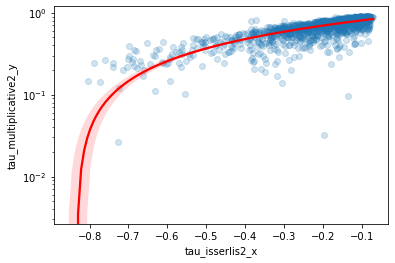

In [ ]:
tmp = tmp_neg[(tmp_neg.array_allele_name_x.notna()) & (tmp_neg.array_allele_name_y.notna())] 
p = sns.regplot(tmp[f'{isserlis}_x'],
            tmp[f'{multiplicative}_y'],
            scatter_kws={'alpha':0.2},
            line_kws={'color': 'red'})
p.set(yscale="log")
print(tmp[[f'{isserlis}_x', f'{multiplicative}_y']].corr(method="spearman"))
print(tmp[[f'{isserlis}_x', f'{multiplicative}_y']].corr(method="pearson"))


In [59]:
import glob

coexpress_dir = "/Users/bjarnold/Princeton_DataX/Epistasis/higher_order_reanalysis/yeast_screens/database/coexpressdb/union"
"""
This directory contains one file per gene, each named with Entrez ID. Each file has a list of each other gene along with a normalized z score
to measure the degree of coexpression.
"""
z = []

entrezID_2_geneName = db.get_entrezID_2_geneName()

coexpression_gene_pairs_set = set()
    #for genes in zip(df[left_gene], df[right_gene]):
    #    gene_physical_pairwise_interactions.add( tuple(sorted((gene_stem_name(genes[0].upper()), gene_stem_name(genes[1].upper())))) )

for file in glob.glob(f"{coexpress_dir}/*"):
    entrez_id_gene1 = int(os.path.basename(file))
    for i in open(file, 'r').readlines():
        i_parse = i.strip().split('\t')
        entrez_id_gene2 = int(i_parse[0])
        coex_z_score = float(i_parse[1])
        if coex_z_score <= -4:
            gene_pair = tuple(sorted((entrezID_2_geneName[entrez_id_gene1], entrezID_2_geneName[entrez_id_gene2])))
            print(int(os.path.basename(file)), int(i_parse[0]), gene_pair)

#sns.histplot(z)

852101 853818 ('ELM1', 'PKH1')
853671 853677 ('STE3', 'STE6')
853613 854397 ('BAT2', 'ODC2')
854431 854734 ('CDC31', 'SEC28')
855110 851894 ('PRO1', 'SEG1')
853677 853671 ('STE3', 'STE6')
851722 855297 ('GFD1', 'MKC7')
856486 852884 ('EFM5', 'NAM8')
851894 855110 ('PRO1', 'SEG1')
854371 850799 ('AHP1', 'LIP5')
853152 855157 ('SAS2', 'YGR237C')
852884 856486 ('EFM5', 'NAM8')
850971 852592 ('PDR8', 'SNF5')
852870 852580 ('DPB3', 'PUF4')
850712 852438 ('BMT2', 'SNF7')
851859 853942 ('BET3', 'HEL2')
854397 853613 ('BAT2', 'ODC2')
854999 850988 ('PUT7', 'SPT5')
853942 851859 ('BET3', 'HEL2')
851243 850307 ('APA1', 'GPB2')
850799 854371 ('AHP1', 'LIP5')
852839 853887 ('DST1', 'HEL1')
856800 851158 ('ARG56', 'CAR2')
850307 851243 ('APA1', 'GPB2')
852862 856724 ('PAC2', 'STT3')
856466 855147 ('ASI1', 'RRP4')
853898 852386 ('BCH2', 'NHP6B')
852386 856204 ('NHP6B', 'YPR089W')
852386 853898 ('BCH2', 'NHP6B')
855157 853152 ('SAS2', 'YGR237C')
851158 856800 ('ARG56', 'CAR2')
850827 856921 ('GRX4', 